# 3. 멀티모달 RAG

PDF 분할 작업을 위해 `unstructured`를 사용합니다. `unstructured` 를 위해 다음과 도구의 설치가 필요합니다:

- `tesseract` : 광학 문자 인식(OCR)을 위해 사용
- `poppler` : PDF 렌더링 및 처리

[poppler 설치 방법](https://pdf2image.readthedocs.io/en/latest/installation.html)과 [tesseract 설치 방법](https://tesseract-ocr.github.io/tessdoc/Installation.html)을 참고하여 설치해주세요.

In [1]:
%%capture --no-stderr
! pip install -U langchain openai chromadb langchain-experimental "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [20]:
# 파일 경로
fpath = 'multimodal_rag/'
fname = "sample.pdf"

In [21]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [22]:
from unstructured.partition.pdf import partition_pdf


# PDF에서 요소 추출
raw_pdf_elements = partition_pdf(
    filename=os.path.join(fpath, fname),
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=fpath,
)

In [23]:
# 텍스트, 테이블 추출
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))  # 테이블 요소 추가
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))  # 텍스트 요소 추가

In [24]:
tables[0]

'2023년 2022년 2024년 42주 2021년 2020년 747 294 420 전체 385 665 356 274 630 382 673 국내발생 74 20 35 29 38 해외유입'

In [25]:
texts[0]

'42주차 (10.13.~10.19.) \n\n| Suyztay | aygises zt | Hail\n\n1주~42주 665명  630명  35명  말라리아  환자  발생  현황  ’24년  1주부터  42주까지  말라리아  환자는  총  665명(인구  10만  명당  발생률  1.3명)이며,  42주에   10명  신규  발생함  전체  665명  중  국내발생  630명(94.7%),  해외유입  35명(5.3%)으로  해외유입  국가는  주로   아프리카  대륙에  속함  전년  726명  대비  61명(8.4%)  감소  국내  발생  현황  (국내  총  630명)  (성별)  남자  526명(83.5%),  여자  104명(16.5%)  (연령) 전체 평균 연령 40.7세(범위 2~97세)이며, 20대 209명(33.2%)으로 가장 많았고, 50대   99명(15.7%), 40대 96명(15.2%), 30대 90명(14.3%), 60대 73명(11.6%) 순으로 발생  (신분)  민간인  479명(76.0%),  현역군인  85명(13.5%),  제대군인  66명(10.5%)  순으로  발생  (지역)  경기 356명(56.5%), 인천 120명(19.0%), 서울 84명(13.3%), 강원 25명(4.0%), 대구 10명(1.6%),   충남 7명(1.1%), 전남 6명(1.0%), 경북 4명(0.6%), 대전, 전북 각 3명(0.5%), 부산, 울산, 광주, 충북,   경남 각 2명(0.3%), 세종, 제주 각 1명(0.2%) 순으로 발생 역학조사 결과 확인된 추정감염지역은   경기  382명(60.6%),  인천  135명(21.4%),  강원  53명(8.4%),  서울  28명(4.4%)  순으로  발생  말라리아  매개모기  감시  현황  (41주)  (매개모기지수)  평균  0.1개체  [평년  0.2  대비  0.1개체  감소  및  전년  0.1  대비  동일]  (원충보유조사)  총  17  pool  (모두  음성) \n\nCO

In [26]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

# 프롬프트 설정
prompt_text = """당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다. 
이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다. 
표 또는 텍스트에 대한 간결한 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요. 표 또는 텍스트: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# 텍스트 요약 체인
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# 제공된 텍스트에 대해 요약을 할 경우
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
# 요약을 원치 않을 경우
# text_summaries = texts

# 제공된 테이블에 적용
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [27]:
table_summaries[0]

'이 텍스트는 특정 연도별 주차에 따른 국내발생 및 해외유입 코로나19 확진자 수를 나타내는 통계 데이터로 보입니다. 2020년부터 2024년까지의 연도별, 주차별 총 확진자 수, 국내발생 확진자 수, 해외유입 확진자 수에 대한 정보가 포함되어 있습니다.'

In [28]:
text_summaries[0]

'42주차 말라리아 환자 발생 현황 보고서에 따르면, 2024년 1주부터 42주까지 총 665명의 말라리아 환자가 발생했으며, 이 중 630명이 국내에서 발생하고 35명이 해외에서 유입된 것으로 확인되었습니다. 이는 전년도 726명에 비해 61명 감소한 수치입니다. 환자들의 성별 분포는 남성이 526명으로 여성 104명보다 많았으며, 연령대는 20대가 가장 많았습니다. 지역별로는 경기도에서 가장 많은 환자가 발생했으며, 그 뒤를 인천, 서울이 이었습니다. 말라리아 매개모기 감시 현황은 평균 0.1개체로, 평년 대비 감소하였습니다.'

In [29]:
import base64


def encode_image(image_path) -> str:
    # 이미지 base64 인코딩
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


# 이미지의 base64 인코딩을 저장하는 리스트
img_base64_list = []

# 이미지를 읽어 base64 인코딩 후 저장
for img_file in sorted(os.listdir(fpath)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(fpath, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)

In [30]:
len(img_base64_list)

42

In [31]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


def image_summarize(img_base64: str) -> str:
    # 이미지 요약
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)
    prompt = """
    당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다. 
    이 요약은 임베딩되어 원본 이미지를 검색하는 데 사용됩니다. 
    이미지 검색에 최적화된 간결한 요약을 작성하세요.
    """
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content


# 이미지 요약을 저장하는 리스트
image_summaries = []

for img_base64 in img_base64_list:
    image_summary = image_summarize(img_base64)
    image_summaries.append(image_summary)


In [32]:
image_summaries[0]

'2024년 말라리아 주간 소식지, 42주차(10.13~10.19), 질병관리청 KDCA, 말라리아 감시 보고서.'

In [33]:
from langchain.retrievers import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# 분할한 텍스트들을 색인할 벡터 저장소
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# 원본문서 저장을 위한 저장소 선언
docstore = InMemoryStore()
id_key = "doc_id"

# 검색기
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

/var/folders/46/rq2wqh8d0kvdvvxsk9sqqqlh0000gn/T/ipykernel_66719/78089293.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag",


In [34]:
import uuid

# 원본 텍스트 데이터 저장
doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

# 원본 테이블 데이터 저장
table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

# 원본 이미지(base64) 데이터 저장
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [35]:
from langchain.schema.document import Document

# 텍스트 요약 벡터 저장 
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)

# 테이블 요약 벡터 저장
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)

# 이미지 요약 벡터 저장

summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)

['e05355d4-2782-4378-8693-df7113b1734a',
 '25563971-05f0-4413-891d-58d753441b1c',
 '779d61f9-6d82-4672-a5d4-aa0e2a3ce1e0',
 'a06f4653-eb63-42d7-bb17-50e556d2d298',
 '4db8a454-4b93-47f5-8d0b-3bcb2eb5fd96',
 '4d5840af-3525-4831-9d99-7c44a944a441',
 '5b2df410-17be-4e9c-872a-bf047486c29d',
 '6d2076d2-24c3-4ce1-8c60-1443941eaee6',
 '39710a3c-2de3-4580-b9f8-672031c29d90',
 '1433938f-2495-4b9a-9323-f4ae67fe1260',
 'f8f92ef8-25ce-4719-809f-19c4a646a77b',
 '47982742-8327-4005-ac39-bf03962dcd54',
 'a163ff5e-9ea0-48fa-868c-e01b35747c4b',
 'f635b9e0-f97f-40d7-9e3d-5432e3fea522',
 'da402d80-058f-4d1b-b5ce-0ff9f59fa2bf',
 'b109ef6b-323b-40a5-af8c-c1a47f66f121',
 '0dce3278-557c-425f-bc29-e307731c8775',
 '2bf9da1f-45db-4628-bb71-1edac1659c03',
 '45fee03e-eb06-4655-b2d7-cdb617c739ae',
 '5c8dc283-6346-4984-8a5d-3f1802c32b1c',
 'df227a8e-6e92-4365-8601-1631fab1b710',
 'f733dba3-9f46-4471-b841-fccb32562af4',
 '2f5fc92a-da8c-4dca-af16-2f990a39229a',
 '6009fc35-ebac-4fcd-a36d-a9be4e5614a8',
 'eff9e843-f9b8-

In [36]:
docs = retriever.invoke(
    "말라리아 군집 사례는 어떤가요? "
)

In [37]:
len(docs)

4

In [38]:
from base64 import b64decode
    
def split_image_text_types(docs):
    # 이미지와 텍스트 데이터를 분리
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }
    
docs_by_type = split_image_text_types(docs)

In [47]:
len(docs_by_type["images"])

3

In [48]:
len(docs_by_type["texts"])

1

In [39]:
docs_by_type["images"]

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABtBRkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3yiiiqAKrXd/a2KBriZUz0HUn8Kz77WmE5tNOVJphxI7Z2x/4mqcOnorGad/tFwxy0j/0HStI0+siZStsTSa3e3JK2NmFTtLMe3qBULLqc4zJqboD2iQL+tWsdPapEhlf7qE1p7sdkZ3bKAs7nvqV4T/11NKIL+PJi1W457

In [40]:
docs_by_type["texts"]

['인천\n\n서울\n\n1\n\n(0.00)\n\n1\n\n(10개)\n\n5\n\n42주차  (10.13.~10.19.)  3  말라리아  군집사례  현황          -  (누적)  4개  시도(경기,  서울,  인천,  강원),  총  46건의  군집사례*  확인                *  군집사례  :  위험지역  내에서  2명  이상의  환자가  증상  발생  간격이  14일  이내,  환자  거주지  거리가   1Km  이내인  경우     표6 군집사례  발생  현황   시군구  발생(군집사례건수)  시·도  사례건수(환자수)  4개  시도  46건(114명)  합계  ▸5명  군집(1)  :  양천구,  강서구(1)   서울  1건(5명)  ▸2명  군집(5)  :  서구(2),  강화군(1),  연수구(1),  중구(1)  5건(10명)  인천  ▸6명  군집(1)  :  파주시(1)  ▸4명  군집(3)  :  파주시(2),  김포시(1),   ▸3명  군집(6)  :  파주시(4),  김포시(1),  일산서구(1)   39건(94명)  경기  ▸2명  군집(29)  :  파주시(15),  김포시(10),  일산동구(2),  일산서구(1),   연천군(1)  ▸5명  군집(1)  :  철원군(1)  1건(5명)  강원  그림  6.  군집사례  6 \n\n3  말라리아  군집사례  현황 ']


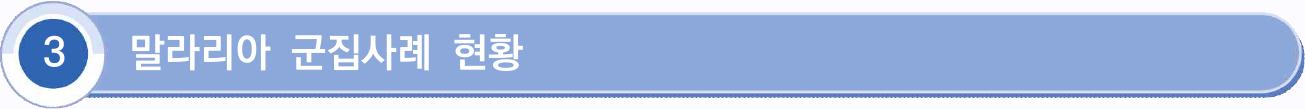

In [41]:

from IPython.display import display, HTML

def plt_img_base64(img_base64):
    # base64 이미지로 html 태그를 작성합니다 
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # html 태그를 기반으로 이미지를 표기합니다 
    display(HTML(image_html))

plt_img_base64(docs_by_type["images"][0])

In [42]:
docs_by_type["texts"][0]

'인천\n\n서울\n\n1\n\n(0.00)\n\n1\n\n(10개)\n\n5\n\n42주차  (10.13.~10.19.)  3  말라리아  군집사례  현황          -  (누적)  4개  시도(경기,  서울,  인천,  강원),  총  46건의  군집사례*  확인                *  군집사례  :  위험지역  내에서  2명  이상의  환자가  증상  발생  간격이  14일  이내,  환자  거주지  거리가   1Km  이내인  경우     표6 군집사례  발생  현황   시군구  발생(군집사례건수)  시·도  사례건수(환자수)  4개  시도  46건(114명)  합계  ▸5명  군집(1)  :  양천구,  강서구(1)   서울  1건(5명)  ▸2명  군집(5)  :  서구(2),  강화군(1),  연수구(1),  중구(1)  5건(10명)  인천  ▸6명  군집(1)  :  파주시(1)  ▸4명  군집(3)  :  파주시(2),  김포시(1),   ▸3명  군집(6)  :  파주시(4),  김포시(1),  일산서구(1)   39건(94명)  경기  ▸2명  군집(29)  :  파주시(15),  김포시(10),  일산동구(2),  일산서구(1),   연천군(1)  ▸5명  군집(1)  :  철원군(1)  1건(5명)  강원  그림  6.  군집사례  6 \n\n3  말라리아  군집사례  현황 '

In [43]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    text = f"""
    다음 문맥에만 기반하여 질문에 답하세요. 문맥에는 텍스트, 표, 그리고 아래 이미지가 포함될 수 있습니다:
    질문: {dict["question"]}
    
    텍스트와 표:
    {format_texts}
    """

    prompt = [
        HumanMessage(
            content=[
                {"type": "text", "text": text},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

    return prompt


model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

# RAG 파이프라인
chain = (
        {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
        | RunnableLambda(prompt_func)
        | model
        | StrOutputParser()
)

In [44]:
chain.invoke(
    "말라리아 군집 사례는 어떤가요?"
)

'말라리아 군집 사례는 총 4개 시도(경기, 서울, 인천, 강원)에서 46건이 확인되었습니다. 인천에서는 5건의 군집 사례가 발생하여 총 10명의 환자가 보고되었습니다. 인천의 군집 사례는 서구(2건), 강화군(1건), 연수구(1건), 중구(1건)에서 발생했습니다.'